### NUS_DATATHON_SINGLIFE
Team Name : **TeamZero**

This notebook provides a detailed overview of our approach in the NUS DATATHON SINGLIFE Competition, focusing on key aspects of data handling and model development:

**Data Analysis:** We delve into the dataset to explore and understand its key features, gaining insights into the underlying patterns and distributions.

**Handling Imbalanced Data:** Strategies are implemented to effectively manage data imbalance, ensuring our model's robustness and accuracy.

**Feature Selection:** Through careful analysis, we identify and select the most impactful features that contribute significantly to our model's performance.

**Model Training & Tuning:** We develop a predictive model, followed by meticulous tuning to enhance its predictive capabilities and ensure optimal performance.

### Methodological Justifications and Detailed Explanations
In this project, we have employed a variety of data preprocessing and modeling techniques. Each method was selected based on specific characteristics of our dataset and the objectives of our analysis. To ensure clarity and transparency, we have provided detailed justifications for our methodological choices. These include, but are not limited to:
1. Imputation Techniques
2. Feature Selection
3. Model Selection
4. Parameter Tuning

For full details, please visit our GitHub repository: https://github.com/reina-peh/NUS-Datathon-2024

<br>


### **Important Reminder:**
Before proceeding to the ```train_model``` and ```test_hidden_data``` sections, please ensure that all the preceding functions in this notebook have been executed. Running these functions is crucial for setting up the necessary environment and preprocessing steps required for the model training and testing phases.

<br>

### LET'S BEGIN!


In [ ]:
!pip install -r requirements.txt

### **Data Cleaning**

### Function 1: ```clean_data(data, target)```

This function targets null values and specific columns for removal. The steps include:

1. Null Value Analysis: It calculates and displays the count and percentage of null values per column.
2. Column Removal: Columns with 100% null values are removed, except for a specified target column. Additional columns deemed redundant ('hh_20', 'pop_20', 'hh_size_est') are also dropped.

### *Function* 2: ```clean_data_v2(data)```

The focus here is on handling 'None' entries, data type conversion, and removing a unique identifier column.

1. 'None' Entries Handling: Counts and percentages of 'None' entries per column are calculated and sorted.
Row Removal: Rows where 'min_occ_date' or 'cltdob_fix' are 'None' are removed, indicating the importance of these fields.
2. Data Type Optimization: Converts all float64 columns to float32 for efficiency.
3. Column Dropping: The 'clntnum' column, a unique identifier, is dropped as it does not contribute to the analysis.

### Function 3: ```clean_target_column(data, target_column_name) ```
This function is dedicated to preprocessing the target column of the dataset. The primary focus is to handle missing values and ensure the data type consistency of the target variable, which is crucial for the accuracy and effectiveness of the model.

In [1]:
def check_duplicates(data, column_name):
    """
    Check for duplicates in a specified column of a DataFrame.

    Parameters:
    data (DataFrame): The DataFrame to check for duplicates.
    column_name (str): The name of the column to check for duplicates.

    Returns:
    tuple: A tuple containing the number of duplicates and a boolean indicating if any duplicates are present.
    """
    # Check for duplicate values in the specified column
    duplicates = data[column_name].duplicated()

    # Count the number of duplicate values
    num_duplicates = duplicates.sum()

    # Check if there are any duplicates
    any_duplicates = duplicates.any()

    return num_duplicates, any_duplicates


In [2]:
import pandas as pd

def clean_data(data, target):
    """
    Cleans the provided DataFrame by dropping columns with certain criteria.

    Parameters:
    data (DataFrame): The DataFrame to clean.
    target (str): The name of the target column to preserve.

    Returns:
    DataFrame: The cleaned DataFrame.
    """
    # Count the number of null values per column
    null_counts = data.isnull().sum()

    # Calculate the percentage of null values
    total_rows = len(data)
    null_percentage = (null_counts / total_rows) * 100

    # Combine the counts and percentages into a DataFrame for a better display
    null_stats = pd.DataFrame({'Number of Nulls': null_counts, 'Percentage of Nulls': null_percentage})

    # Sort by 'Percentage of Nulls'
    null_stats.sort_values(by='Percentage of Nulls', ascending=False, inplace=True)

    # Find columns where the percentage of null values is 100%
    columns_to_drop = null_percentage[null_percentage == 100].index

    # Ensure the target column is not in the list of columns to drop
    columns_to_drop = [col for col in columns_to_drop if col != target]

    # Drop these columns
    data_cleaned = data.drop(columns=columns_to_drop)

    # Drop 'hh_20', 'pop_20', 'hh_size_est' since hh_20 divided by pop_20 gives
    # values in an existing columns 'hh_size' and 'hh_size_est' contains values rounded off from 'hh_size'
    columns_to_drop_also = ['hh_20', 'pop_20', 'hh_size_est']
    data_cleaned.drop(columns=columns_to_drop_also, axis=1, inplace=True)

    return data_cleaned

In [3]:
import pandas as pd

def clean_data_v2(data):
    """
    Further cleans the provided DataFrame.

    Parameters:
    data (DataFrame): The DataFrame to clean.

    Returns:
    DataFrame: The cleaned DataFrame.
    """
    # Count the number of 'None' entries per column
    none_counts = data.apply(lambda x: (x == 'None').sum())

    # Calculate the percentage of 'None' entries
    total_rows = len(data)
    none_percentage = (none_counts / total_rows) * 100

    # Combine the counts and percentages into a DataFrame for a better display
    none_stats = pd.DataFrame({'Number of None Entries': none_counts, 'Percentage of None Entries': none_percentage})

    # Sort by 'Percentage of None Entries'
    none_stats.sort_values(by='Percentage of None Entries', ascending=False, inplace=True)

    # Check if either 'min_occ_date' or 'cltdob_fix' have 'None' values
    condition = (data['min_occ_date'] == 'None') | (data['cltdob_fix'] == 'None')

    # Remove rows that satisfy the condition
    data = data[~condition]

    # Convert all float64 columns to float32
    float_cols = data.select_dtypes(include=['float64']).columns
    data[float_cols] = data[float_cols].astype('float32')

    # Drop 'clntnum' column
    data.drop('clntnum', axis=1, inplace=True)

    return data


In [4]:
def clean_target_column(data, target_column_name):

    # Replace NaN values with 0
    data[target_column_name] = data[target_column_name].fillna(0)

    # Convert 1.0 to 1
    data[target_column_name] = data[target_column_name].apply(lambda x: 1 if x == 1.0 else x)

    return data


###Feature Engineering

We have identified that age at which a customer purchases an insurance policy is important, hence we created a new column to calculate their age using ```min_occ_date``` and ```cltdob_fix```

In [5]:
# feature engineering

def calculate_age(data, date_column_1, date_column_2):

    # Ensure the date columns are in datetime format
    data[date_column_1] = pd.to_datetime(data[date_column_1])
    data[date_column_2] = pd.to_datetime(data[date_column_2])

    # Calculate age in decimal years
    data['client_age'] = (data[date_column_1] - data[date_column_2]).astype('timedelta64[Y]').astype('int')

    # Drop the specified date columns
    data.drop(columns=[date_column_1, date_column_2], inplace=True)

### **Train Test Split to divide a dataset into training and testing subsets for model training and evaluation**

In [6]:
from sklearn.model_selection import train_test_split

def create_data_split(data, target, test_size=0.2, random_state=42):
    """
    Splits the data into training and validation sets and defines the features.

    Parameters:
    data (DataFrame): The cleaned DataFrame to be split.
    target (str): The name of the target column.
    test_size (float, optional): The proportion of the dataset to include in the validation split. Default is 0.2.
    random_state (int, optional): The random state for reproducibility. Default is 42.

    Returns:
    tuple: A tuple containing the training set, validation set, and features list.
    """
    # Create single fold split
    tr, val = train_test_split(data, test_size=test_size, random_state=random_state)

    # Define the features
    features = [col for col in data.columns if col != target]

    return tr, val, features


### **Data Imputation: Addressing NaN or None Values**

**Challenges with Missing Data:** Our dataset contained NaN or None values, which posed a significant challenge for performing accurate statistical analyses and data visualizations. The choice of imputation technique was critical to preserve data integrity and maintain the reliability of our analyses.

**Why Median Imputation?**

- **Robustness Against Outliers and Skewed Distributions:** Median imputation was chosen for its robustness in the presence of outliers and skewed data distributions. Unlike the mean, which can be heavily influenced by extreme values, the median provides a more representative value of the central tendency in such cases.

- **Maintaining Data Integrity:** The median imputation helps in preserving the original distribution of the dataset. This is crucial for maintaining the structural integrity of the data, ensuring that subsequent analyses are reflective of the true nature of the underlying data.

**Alternatives Considered and Their Limitations:**

- **Mean Imputation:** Simple imputer mean was considered; however, its susceptibility to outliers made it less suitable for our dataset. Mean imputation could potentially introduce bias, especially in skewed distributions, leading to distorted analyses.

- **Simplicity and Efficiency:** Given the size and nature of our dataset, median imputation offered a balance between simplicity, computational efficiency, and effectiveness. This method allowed us to quickly and effectively address missing values, enabling us to proceed with our analyses without introducing significant bias.


In [7]:
from sklearn.experimental import enable_iterative_imputer  # Import to enable IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
import numpy as np

def impute_data(tr, features, val=None):
    """
    Imputes missing values in numeric and non-numeric features in the training dataset and, optionally, the validation dataset.

    Parameters:
    tr (DataFrame): The training dataset.
    features (list of str): The list of feature names.
    val (DataFrame, optional): The validation dataset. If None, only the training dataset will be imputed.

    Returns:
    DataFrame, (DataFrame): The imputed training dataset and, if provided, the imputed validation dataset.
    """
    # Identify numeric and non-numeric features
    numeric_features = tr[features].select_dtypes(include=[np.number]).columns
    non_numeric_features = tr[features].select_dtypes(exclude=[np.number]).columns

    # Impute numeric features using Iterative Imputer
    imputer_numeric = IterativeImputer(max_iter=10, initial_strategy='median', random_state=0)
    tr[numeric_features] = imputer_numeric.fit_transform(tr[numeric_features])

    # Impute non-numeric features using Simple Imputer
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    tr[non_numeric_features] = imputer_categorical.fit_transform(tr[non_numeric_features])

    if val is not None:
        val[numeric_features] = imputer_numeric.transform(val[numeric_features])
        val[non_numeric_features] = imputer_categorical.transform(val[non_numeric_features])
        return tr, val
    else:
        return tr


### Under-Over Sampling Technique

In our data preprocessing phase, we implemented a combined under-over sampling strategy to address the class imbalance in our dataset. Class imbalance is a common issue in machine learning, where some classes are underrepresented compared to others. This imbalance can lead to biased models that don't perform well on minority classes.

**Why We Chose Under-Over Sampling:**

- **Under-Sampling**: We first applied Random Under-Sampling to reduce the size of the overrepresented class. This approach helps in balancing the class distribution and reducing the training dataset size, which can be beneficial for computational efficiency.

- **Over-Sampling with SMOTENC**: After under-sampling, we used SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous data) for over-sampling the minority class. Unlike basic over-sampling techniques, SMOTENC generates synthetic samples for the minority class in a more sophisticated manner, considering both nominal and continuous features. This leads to a more balanced and representative training dataset.

- **Combining Both Techniques**: By combining under-sampling and over-sampling, we aimed to create a more balanced dataset without losing significant information. This combination helps in improving the model's performance, especially its ability to predict minority class instances, leading to more reliable and generalized outcomes.

By carefully addressing the class imbalance using this combined approach, we enhanced the model's ability to learn from a more representative dataset, thereby improving its predictive performance on unseen data.


In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

def under_over_sampling(tr, features, target, under_sampling_strategy=0.1, random_state=42):
    """
    Applies undersampling and then oversampling to the training dataset.

    Parameters:
    tr (DataFrame): The training dataset.
    features (list of str): The list of feature names.
    target (str): The name of the target column.
    under_sampling_strategy (float, optional): The sampling strategy for undersampling. Default is 0.1.
    random_state (int, optional): The random state for reproducibility. Default is 42.

    Returns:
    DataFrame, array: The resampled features DataFrame and target array.
    """
    # Initialize RandomUnderSampler
    rus = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=random_state)

    # Extract features and target
    X = tr[features]
    y = tr[target].to_numpy()

    # Apply undersampling
    X_under, y_under = rus.fit_resample(X, y)

    # Convert object types to string
    for col in X_under.select_dtypes(include='object'):
        X_under[col] = X_under[col].astype(str)

    # Identify categorical feature indices for SMOTENC
    categorical_features_indices = [X_under.columns.get_loc(col) for col in X_under.columns if X_under[col].dtype == 'object']

    # Initialize SMOTENC with the correct indices
    smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=random_state)

    # Apply SMOTENC for oversampling
    X_resampled, y_resampled = smote_nc.fit_resample(X_under, y_under)

    return X_resampled, y_resampled


In [9]:
import numpy as np
import pandas as pd

def extract_numeric_features(data, features):
    """
    Extracts numeric features from a specified subset of a DataFrame.

    Parameters:
    data (DataFrame): The DataFrame from which to extract numeric features.
    features (list of str): The list of feature names to consider for extraction.

    Returns:
    DataFrame: A DataFrame containing only the numeric features from the specified subset.
    """
    # Filter the DataFrame to include only the specified features
    data_filtered = data[features]

    # Identify numeric features from the filtered DataFrame
    numeric_features = data_filtered.select_dtypes(include=[np.number]).columns

    # Create a DataFrame with only numeric features from the filtered subset
    numeric_data = data_filtered[numeric_features]

    return numeric_data


### **Feature Selection**

**Understanding Key Influencers in High-Dimensional Data:** In our project, the primary challenge was to decipher the most influential factors from a dataset that originally contained over 200 columns. Such a high-dimensional dataset can obscure crucial insights, especially when analyzing complex customer behaviors. To navigate this, a strategic approach to feature selection was essential.

**Integrating XGBClassifier with SelectFromModel:**

- **Utilizing a Strong Classifier:** We employed the XGBClassifier, renowned for its effectiveness in classification tasks and its capability to rank feature importance. XGBoost, with its gradient boosting framework, excels in handling various types of data and uncovering complex patterns. Its intrinsic feature importance metric provides a reliable basis for feature selection.

- **SelectFromModel Methodology:** The SelectFromModel method was applied in tandem with the XGBClassifier. This method analyzes the feature importance scores generated by the classifier and retains only the most significant features. For our project, we chose to keep the top 40 features. This threshold was thoughtfully selected to ensure that we retain enough features to capture the diverse aspects of customer behavior while avoiding the pitfalls of model overcomplexity and potential overfitting.

**Why SelectFromModel Over RFE or PCA?**

- **Computational Efficiency:** Recursive Feature Elimination (RFE) is inherently iterative and computationally demanding, especially with a large number of features. In contrast, SelectFromModel offers a more computationally efficient alternative.

- **Preserving Interpretability with PCA Limitations:** While PCA is effective for reducing dimensionality, it transforms the original features into principal components, which can be challenging to interpret, especially in a business context where understanding specific feature influences is crucial. SelectFromModel maintains the original features, making the results more interpretable and actionable.

- **Balancing Feature Set and Model Complexity:** The goal was to distill the dataset to a manageable number of features without losing critical information. SelectFromModel, coupled with XGBClassifier, provided a more nuanced approach to achieving this balance compared to the broad dimensionality reduction offered by PCA or the intensive feature elimination process of RFE.

**Outcome and Impact:**

By implementing this feature selection strategy, we were able to significantly reduce the feature space from over 200 to 40, focusing on the most relevant variables that influence customer behavior. This not only enhanced the model's performance by reducing noise and complexity but also aided in interpretability, allowing for more straightforward insights and decision-making based on the model's outputs.


In [10]:
  import numpy as np
  from sklearn.feature_selection import SelectFromModel
  from xgboost import XGBClassifier

  def select_features(X_train_numeric, y_resampled, X_val_numeric=None, max_features=40):
      """
      Applies feature selection using SelectFromModel with XGBClassifier on the numeric features.
      Optionally applies the same selection to a provided validation dataset.

      Parameters:
      X_train_numeric (DataFrame): Numeric features of the resampled training dataset.
      y_resampled (array): The target array after resampling.
      X_val_numeric (DataFrame, optional): Numeric features of the validation dataset.
      max_features (int, optional): The maximum number of features to select.

      Returns:
      DataFrame, SelectFromModel, (DataFrame): Transformed training dataset, the feature selector, and, if provided, transformed validation dataset.
      """
      # Initialize SelectFromModel with XGBClassifier
      feature_selector = SelectFromModel(
          estimator=XGBClassifier(),
          threshold=-np.inf,
          max_features=max_features
      )

      # Apply feature selection to the training data
      X_train_selected = feature_selector.fit_transform(X_train_numeric, y_resampled)

      # If validation data is provided, apply the same feature selection to it
      X_val_selected = None
      if X_val_numeric is not None:
          X_val_selected = feature_selector.transform(X_val_numeric)

      return X_train_selected, feature_selector, X_val_selected


## Understanding which features are the most important

This funciton aims to provide a clear view of what drives the model's decision-making process across the whole dataset.

With this knowledge, we can identify which features exert the most influence on our model's predictions!

In [11]:
def get_selected_feature_names(feature_selector, column_names):
    """
    Retrieves the names of the selected features after feature selection.

    Parameters:
    feature_selector (SelectFromModel): The fitted feature selector object.
    column_names (list): The list of original column names from the dataset.

    Returns:
    list: The names of the selected features.
    """
    # Extract the boolean mask of selected features
    selected_features_mask = feature_selector.get_support()

    # Get the names of the selected features based on the mask
    selected_feature_names = [column_names[i] for i in range(len(column_names)) if selected_features_mask[i]]

    return selected_feature_names


### **Model Training**

In the training stage, we opted for the XGBoost classifier, guided by a comparative performance analysis against models like Logistic Regression, SVM, and KNN. The `pretrain_model` function is responsible for initializing the XGBClassifier with chosen hyperparameters and fitting it to the training data. Below are the key theoretical reasons for selecting XGBoost:

1. **Ensemble Learning Method**: XGBoost leverages an advanced form of gradient boosting, an ensemble technique where multiple weak learners (decision trees) are combined in a sequential manner. Each tree in the sequence corrects the errors of its predecessors, culminating in a robust overall model.

2. **Regularization Techniques**: It includes L1 and L2 regularization, which significantly reduce the risk of overfitting, a crucial advantage over traditional models, particularly in complex datasets.

3. **Versatile Data Handling**: XGBoost efficiently processes a mix of categorical and numerical features, outperforming models like Logistic Regression and KNN that often require extensive preprocessing for different data types.

4. **Optimized Performance and Speed**: Designed for high performance and speed, XGBoost optimizes computational resources and memory usage, making it more scalable and faster than conventional algorithms, especially in handling large datasets.

These factors combined — the ensemble approach, regularization, versatility in data handling, and optimized performance — make XGBoost an excellent choice for our dataset, leading to superior accuracy and efficiency compared to the alternatives.


In [12]:
import xgboost as xgb

def pretrain_model(X_train_selected, y_resampled):
    """
    Trains an XGBClassifier on the selected training features.

    Parameters:
    X_train_selected (DataFrame or array): Selected features of the training dataset.
    y_resampled (array): The target array after resampling.

    Returns:
    XGBClassifier: The trained XGBClassifier model.
    """

    clf = xgb.XGBClassifier(
        objective = 'binary:logistic',
        learning_rate = 0.22145013353887077,
        gamma = 4.3039462306959395,
        max_depth = 8,
        min_child_weight = 4,
        subsample = 0.6099674904240726,
        colsample_bytree = 0.6033130913572766,
        reg_lambda = 0.0005851643553019946,
        reg_alpha = 0.04115841889918572,
        use_label_encoder = False,
        eval_metric = 'logloss'
    )

    clf.fit(X_train_selected, y_resampled)

    return clf


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def predict_evaluate(model, X_val_selected, val_target):
    """
    Makes predictions with the trained model on the validation set and evaluates them.

    Parameters:
    model (XGBClassifier): The trained XGBClassifier model.
    X_val_selected (DataFrame or array): Selected features of the validation dataset.
    val_target (array): The actual target variable of the validation dataset.

    Returns:
    dict: A dictionary containing the precision, recall, and F1 score.
    """
    y_pred = model.predict(X_val_selected)

    precision = precision_score(val_target, y_pred, average='binary')
    recall = recall_score(val_target, y_pred, average='binary')
    f1 = f1_score(val_target, y_pred, average='binary')

    return {"Precision": precision, "Recall": recall, "F1 Score": f1}


### **Hyperparameter Optimization with Optuna for XGBoost Model**

We focused on optimising the hyperparameters of an XGBoost classifier using the Optuna library. The goal is to find the best combination of hyperparameters that maximizes the F1 score of the model on the validation dataset. This is achieved through a systematic and efficient search across a specified range of hyperparameter values.

In [ ]:
import optuna
import xgboost as xgb
import numpy as np
import sklearn.metrics

def optimize_hyperparameters(X_train_selected, y_resampled, X_val_selected, val_target, n_trials=100):
    """
    Optimize hyperparameters for XGBoost using Optuna.

    Parameters:
    X_train_selected (DataFrame): Selected features of the training dataset.
    y_resampled (array): The target array after resampling.
    X_val_selected (DataFrame): Selected features of the validation dataset.
    val_target (array): The actual target variable of the validation dataset.
    n_trials (int, optional): The number of optimization trials. Default is 100.

    Returns:
    optuna.study.Study: The Optuna study object after completing the optimization.
    """

    def objective(trial):
        param = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'gamma': trial.suggest_float('gamma', 0.1, 5),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'lambda': trial.suggest_loguniform('lambda', 1e-4, 1.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-4, 1.0)
        }

        dtrain = xgb.DMatrix(X_train_selected, label=y_resampled)
        dvalid = xgb.DMatrix(X_val_selected, label=val_target)

        bst = xgb.train(param, dtrain)
        preds = bst.predict(dvalid)
        pred_labels = np.rint(preds)
        f1 = sklearn.metrics.f1_score(val_target, pred_labels)
        return f1

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return study


In [ ]:
# Studying Tuning Methods
# study = optimize_hyperparameters(X_train_selected, y_resampled, X_val_selected, imputed_validation_set[target], n_trials=100)


In [ ]:
# study.best_params




### **Preprocessing Test Data (Used for unseen data)**
These are used by the ```test_hidden_data``` function

In [14]:
from sklearn.experimental import enable_iterative_imputer  # Import to enable IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer
import numpy as np

def impute_validation_set(val, features):
    """
    Imputes missing values in numeric and non-numeric features in the validation dataset.

    Parameters:
    val (DataFrame): The validation dataset.
    features (list of str): The list of feature names.

    Returns:
    DataFrame: The imputed validation dataset.
    """
    # Identify numeric and non-numeric features
    numeric_features = val[features].select_dtypes(include=[np.number]).columns
    non_numeric_features = val[features].select_dtypes(exclude=[np.number]).columns

    # Initialize and fit Iterative Imputer for numeric features
    imputer_numeric = IterativeImputer(max_iter=10, initial_strategy='median', random_state=0)
    val_numeric_imputed = imputer_numeric.fit_transform(val[numeric_features])

    # Initialize and fit Simple Imputer for non-numeric features
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    val_non_numeric_imputed = imputer_categorical.fit_transform(val[non_numeric_features])

    # Update the DataFrame with imputed values
    val[numeric_features] = val_numeric_imputed
    val[non_numeric_features] = val_non_numeric_imputed

    return val


In [15]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

def apply_feature_selection_validation(X_val_numeric, feature_selector):
    """
    Applies the feature selection process to the validation dataset.

    Parameters:
    X_val_numeric (DataFrame): Numeric features of the validation dataset.
    feature_selector (SelectFromModel): The feature selector fitted on the training data.

    Returns:
    DataFrame: The validation dataset with selected features.
    """
    X_val_selected = feature_selector.transform(X_val_numeric)
    return X_val_selected

### **Model Training**

The ```train_model``` function is designed to train a predictive model using XGBoost on a specified dataset. It performs several preprocessing steps including data cleaning, feature selection, and handling class imbalance, before training the model.

## Usage:

1. Prepare Your Dataset:
As we are not saving our model, please run this function on the original ```catB_train.parquet``` dataset.

2. Train the Model:
Call the train_model function with the file path of your dataset. It returns a tuple containing the trained XGBoost model and the feature selector used during training.


```
model, feature_selector = train_model("path_to_your_dataset.parquet")
```



In [16]:
import pandas as pd
import sklearn
import xgboost as xgb

def train_model(filePath):
    """
    Trains a model on the data from the provided data file path.

    Parameters:
    filePath (str): The file path to the dataset.

    Returns:
    XGBClassifier: The trained XGBoost model.
    """
    # Load the data from the provided file path
    data = pd.read_parquet(filePath)
    target = 'f_purchase_lh'

    data_cleaned = clean_data(data, target)

    # To further clean the data
    data_cleaned = clean_data_v2(data_cleaned)

    # Clean Target Column
    data_cleaned = clean_target_column(data_cleaned, target)

    # Create Age of User
    calculate_age(data_cleaned, 'min_occ_date', 'cltdob_fix')

     # Define the features
    features = [col for col in data_cleaned.columns if col != target]

    # Implement Data Imputation
    imputed_set = impute_data(data_cleaned, features)

    # Implement Under Over Sampling
    X_resampled, y_resampled = under_over_sampling(imputed_set, features, target)

    # Sample Numeric Data
    X_sampled_numeric = extract_numeric_features(X_resampled, features)

    # Feature Selection
    X_train_selected, feature_selector, _ = select_features(X_sampled_numeric, y_resampled)

    # Train the model
    model = pretrain_model(X_train_selected, y_resampled)

    return model, feature_selector

In [17]:
# Example Function Invocation
model, feature_selector = train_model("catB_train.parquet")

### **Testing Hidden Data**

The ```testing_hidden_data``` function is used to apply a trained model to a test dataset. It handles preprocessing steps such as data cleaning and feature selection before making predictions.

1. Prepare Your Test Dataset:
The test dataset should be in a Parquet file format and contain the same structure and feature naming convention as the training dataset.

2. Make Predictions:
Use the function by providing the trained model, the feature selector, and the file path to your test dataset. The function returns the predictions and the true labels from the test set.



```
 y_pred, y_test = testing_hidden_data(trained_model, feature_selector, "path_to_test_data.parquet")
```




In [18]:
def testing_hidden_data(model, feature_selector, testDatafilePath):
    """
    Imputes missing values, applies feature selection, and makes predictions on a test dataset.

    Parameters:
    model (XGBClassifier): The trained XGBClassifier model.
    X_test (DataFrame or array): Features of the test dataset.

    Returns:
    array: The predictions made by the model.
    """

    target = 'f_purchase_lh'

    if testDatafilePath.endswith('.parquet'):
        X_test = pd.read_parquet(testDatafilePath)
    elif testDatafilePath.endswith('.csv'):
        X_test = pd.read_csv(testDatafilePath)

    data_cleaned = clean_data(X_test, target)

    # To further clean the data
    data_cleaned = clean_data_v2(data_cleaned)

    # Clean Target Column
    data_cleaned = clean_target_column(data_cleaned, target)

    # Create Age of User
    calculate_age(data_cleaned, 'min_occ_date', 'cltdob_fix')

    # Define the features
    features = [col for col in data_cleaned.columns if col != target]

    # Impute the test data
    X_test_imputed = impute_validation_set(data_cleaned, features)

    # Sample Numeric Data
    X_test_imputed = extract_numeric_features(X_test_imputed, features)

    # Apply feature selection
    X_test_selected = apply_feature_selection_validation(X_test_imputed, feature_selector)

    # test labels
    y_test = data_cleaned[target]

    # Make predictions
    y_pred = model.predict(X_test_selected)

    return y_pred, y_test, X_test_selected # Return the predictions and the test labels


In [ ]:
#Sample Method Invocation

#replace catB_train.parquet with the test file
y_pred, y_test, X_test_selected = testing_hidden_data(model, feature_selector, "catB_train.parquet")
print(y_pred)

### Evaluation Metrics: Precision, Recall, and F1 Score

**Precision** measures the accuracy of positive predictions. It is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). A higher precision score indicates that the model is more accurate in predicting positive cases.

**Recall** (Sensitivity) measures the model's ability to correctly identify all positive cases. It is the ratio of true positive predictions to the actual number of positive cases (true positives + false negatives). Higher recall indicates that the model is better at catching all positive cases.

**F1 Score** is the harmonic mean of precision and recall. It is a balance between precision and recall, providing a single metric that summarizes the model's accuracy. An F1 score reaches its best value at 1 (perfect precision and recall) and its worst at 0.

These metrics are particularly useful in scenarios where classes are imbalanced or when the costs of false positives and false negatives are very different.



In [20]:
# #Sample Method Invocation

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     17252
         1.0       0.43      0.38      0.41       708

    accuracy                           0.96     17960
   macro avg       0.70      0.68      0.69     17960
weighted avg       0.95      0.96      0.95     17960

Accuracy: 0.9556792873051225


# Explanable AI: Shining a Light on Predictive Insights

### Unraveling the Mystery: How We Predict Insurance Purchasing Behavior

To achieve this level of comprehension, we employed two pivotal methods within the scope of Explainable AI (XAI):

1. **Feature Selection and Visualization:** Initially, we harnessed a specific function to identify and extract the names of the most influential features within our dataset. This step was instrumental in narrowing down the vast array of variables to those with the most significant impact on our predictions. Following this selection, we plotted these features to visually represent their importance, making it easier to grasp how each contributes to the model's decision-making process.

2. **Local Interpretable Model-agnostic Explanations (LIME):** To dive deeper into the 'why' and 'how' of individual predictions, we turned to LIME. This method allowed us to break down each prediction, providing clear, understandable explanations of the model's behavior on a case-by-case basis. By employing LIME, we could pinpoint the exact features and their contributions that led to specific predictions, offering a granular view of our model's inner workings.

In [ ]:
# DETERMINING GLOBAL FEATURE IMPORTANCE

data = pd.read_parquet("catB_train.parquet")
target = 'f_purchase_lh'

data_cleaned = clean_data(data, target)

# To further clean the data
data_cleaned = clean_data_v2(data_cleaned)

# Clean Target Column
data_cleaned = clean_target_column(data_cleaned, target)

# Create Age of User
calculate_age(data_cleaned, 'min_occ_date', 'cltdob_fix')

# Define the features
features = [col for col in data_cleaned.columns if col != target]

# Impute the test data
X_test_imputed = impute_validation_set(data_cleaned, features)

# Sample Numeric Data
X_test_imputed = extract_numeric_features(X_test_imputed, features)


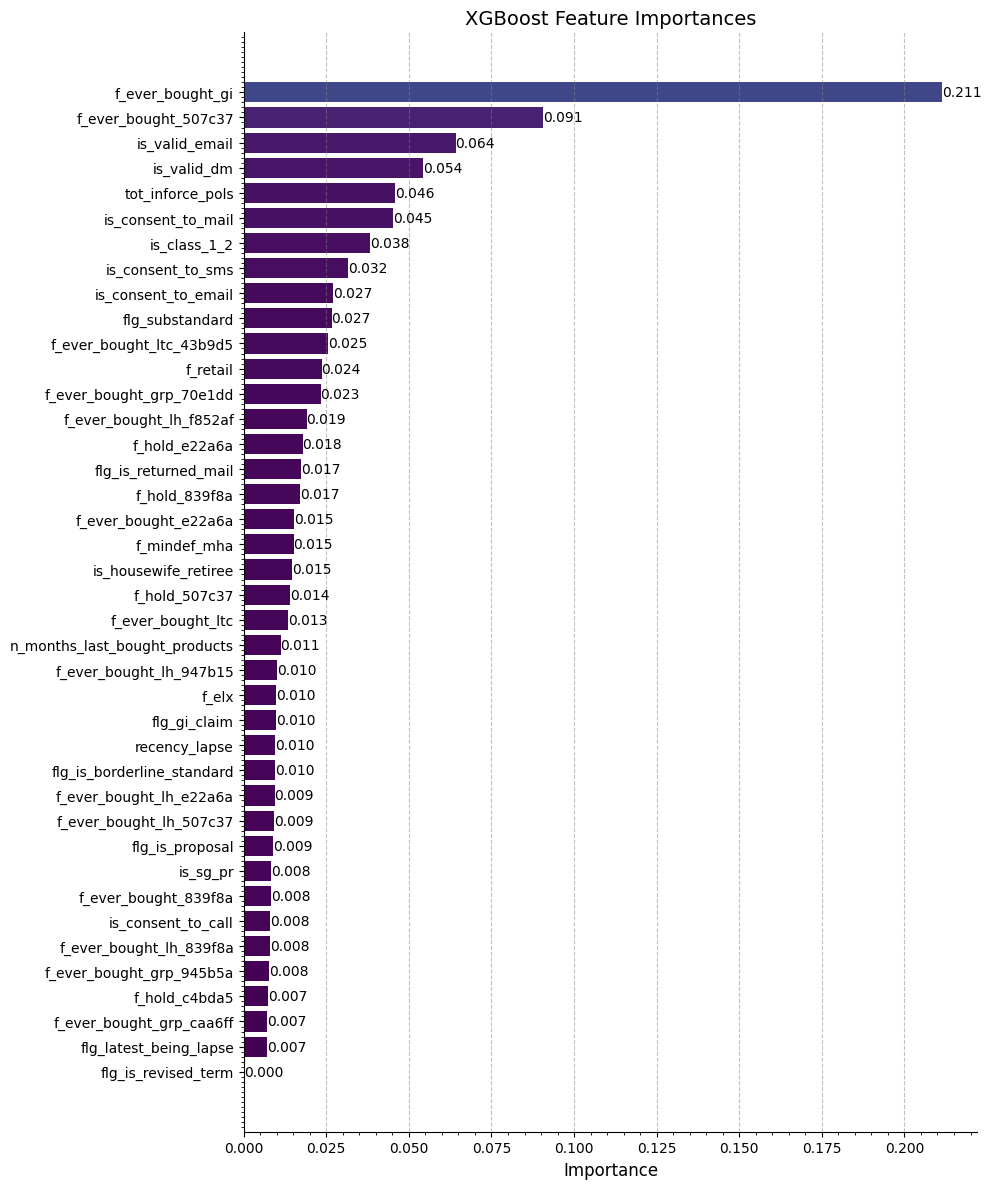

In [25]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importances = model.feature_importances_
selected_features_mask = feature_selector.get_support()
selected_features = X_test_imputed.columns[selected_features_mask]

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_sorted = importances_df.sort_values('Importance', ascending=True)

# Plotting with enhancements
plt.figure(figsize=(10, 12))
colors = plt.cm.viridis(df_sorted['Importance'])  # Apply a color map based on importance
bars = plt.barh(df_sorted['Feature'], df_sorted['Importance'], color=colors)
plt.xlabel('Importance', fontsize=12)
plt.title('XGBoost Feature Importances', fontsize=14)

# Remove top and right spines for a cleaner look
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5, color='grey')
plt.minorticks_on()

# Annotate each bar with the exact importance value
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.3f}",
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()

# Save the figure as an SVG file with a transparent background
plt.savefig("xgboost_feature_importances.svg", format='svg', transparent=True)

plt.show()


# **LIME**

To dive deeper into the 'why' and 'how' of individual predictions

In [ ]:
!pip install lime

In [ ]:
# Initialize the explainer
import lime
import lime.lime_tabular

# Apply feature selection
X_test_selected = apply_feature_selection_validation(X_test_imputed, feature_selector)

y_train = data_cleaned[target]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_test_selected,
    feature_names=features,
    mode='classification',
    verbose=False,
    training_labels=y_test,
    discretize_continuous=True)

In [ ]:
import numpy as np

# List to store the explanations for person who did not buy the insurance
all_explanations = []

# Generate explanations 100 times
for _ in range(100):
    exp = explainer.explain_instance(X_test_selected[0], model.predict_proba, num_features=20).as_list()
    all_explanations.append(exp)

# Initialize dictionaries to keep track of the sum and count of coefficients for each feature
coefficients_sum = {}
coefficients_count = {}

# Process each explanation in the list of explanations
for lime_explanation in all_explanations:
    for feature, coefficient in lime_explanation:
        if feature in coefficients_sum:
            # Add coefficient to the existing sum and increment the count for this feature
            coefficients_sum[feature] += coefficient
            coefficients_count[feature] += 1
        else:
            # Initialize sum and count for this new feature
            coefficients_sum[feature] = coefficient
            coefficients_count[feature] = 1

# Calculate the mean coefficient for each feature
coefficients_mean = {feature: coefficients_sum[feature] / coefficients_count[feature] for feature in coefficients_sum}

# Optional: Normalize coefficients
sum_abs = sum(abs(value) for value in coefficients_mean.values())
normalized_coefficients = {feature: value / sum_abs for feature, value in coefficients_mean.items()}

# print("Average Coefficients:", coefficients_mean)
# print("Normalized Coefficients:", normalized_coefficients)


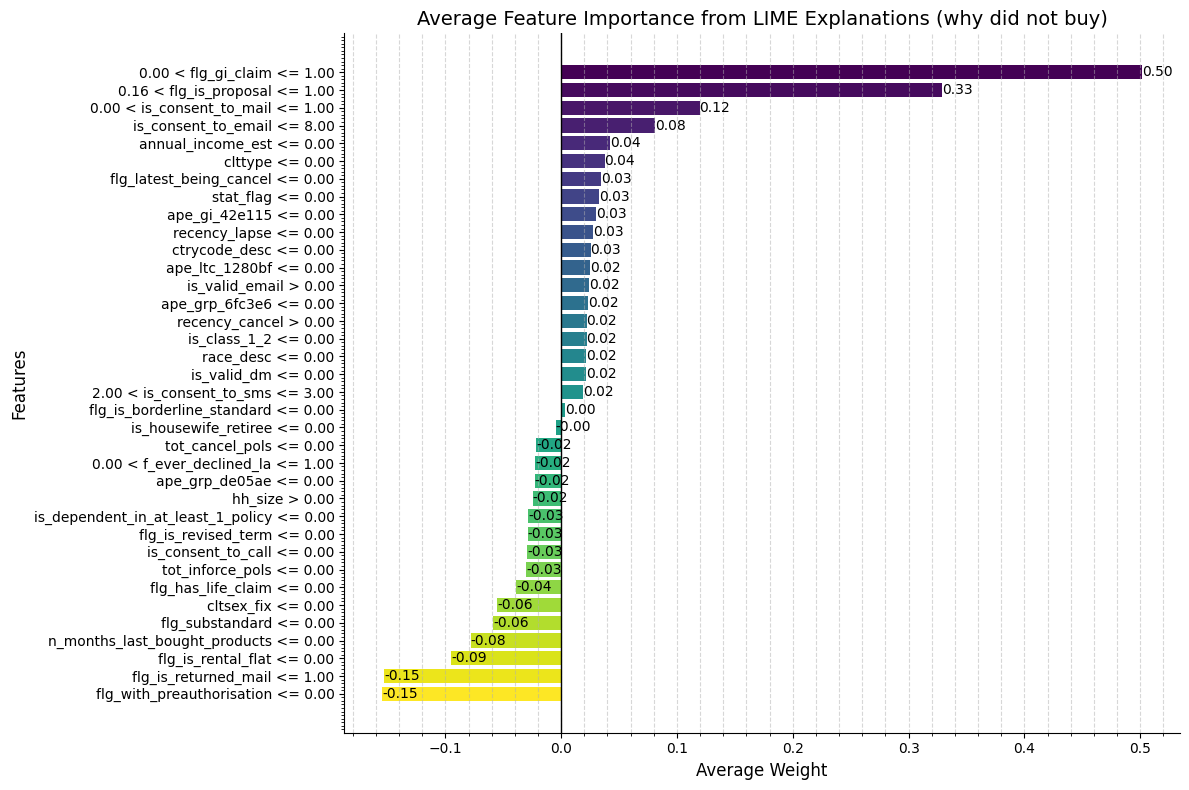

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Initialize dictionaries for sum and count of coefficients for each feature
coefficients_sum = defaultdict(float)
coefficients_count = defaultdict(int)

# Aggregate data
for explanation in all_explanations:
    for feature, coefficient in explanation:
        coefficients_sum[feature] += coefficient
        coefficients_count[feature] += 1

# Calculate average coefficient for each feature
coefficients_avg = {feature: coefficients_sum[feature] / coefficients_count[feature] for feature in coefficients_sum}

# Sort features by their average importance
sorted_features = sorted(coefficients_avg.items(), key=lambda x: x[1], reverse=True)

# Split features and their average importance for plotting
features, avg_importances = zip(*sorted_features)

# Create a bar plot with enhancements
plt.figure(figsize=(12, 8))  # Increased figure size
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))  # Use a colormap for differentiation
bars = plt.barh(features, avg_importances, color=colors)
plt.xlabel('Average Weight', fontsize=12)  # Adjust font size
plt.ylabel('Features', fontsize=12)
plt.title('Average Feature Importance from LIME Explanations (why did not buy)', fontsize=14)
plt.gca().invert_yaxis()  # Keep the most important feature on top

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(axis='x', which='both', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.axvline(x=0, color='black', linewidth=1)

# Add value labels to each bar
for bar in bars:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va='center', ha='left', fontsize=10, color='black'
    )

plt.tight_layout()
# Save the figure as an SVG file
plt.savefig("feature_importance_didntbuy.svg", format='svg', transparent=True)

plt.show()


## **Exploring data for a random individual who bought an insurance**

In [ ]:
# List to store the explanations
test_explanations = []

# Generate explanations 100 times
for _ in range(100):
    exp = explainer.explain_instance(X_test_selected[2781], model.predict_proba, num_features=20).as_list()
    test_explanations.append(exp)

In [ ]:
import numpy as np

# Example LIME explanations (coefficients for each feature)
# lime_explanations = test_explanations

# Initialize dictionaries to keep track of the sum and count of coefficients for each feature
coefficients_sum = {}
coefficients_count = {}

# Process each explanation in the list of explanations
for lime_explanation in test_explanations:
    for feature, coefficient in lime_explanation:
        if feature in coefficients_sum:
            # Add coefficient to the existing sum and increment the count for this feature
            coefficients_sum[feature] += coefficient
            coefficients_count[feature] += 1
        else:
            # Initialize sum and count for this new feature
            coefficients_sum[feature] = coefficient
            coefficients_count[feature] = 1

# Calculate the mean coefficient for each feature
coefficients_mean = {feature: coefficients_sum[feature] / coefficients_count[feature] for feature in coefficients_sum}

# Optional: Normalize coefficients
sum_abs = sum(abs(value) for value in coefficients_mean.values())
normalized_coefficients = {feature: value / sum_abs for feature, value in coefficients_mean.items()}

# print("Average Coefficients:", coefficients_mean)
# print("Normalized Coefficients:", normalized_coefficients)

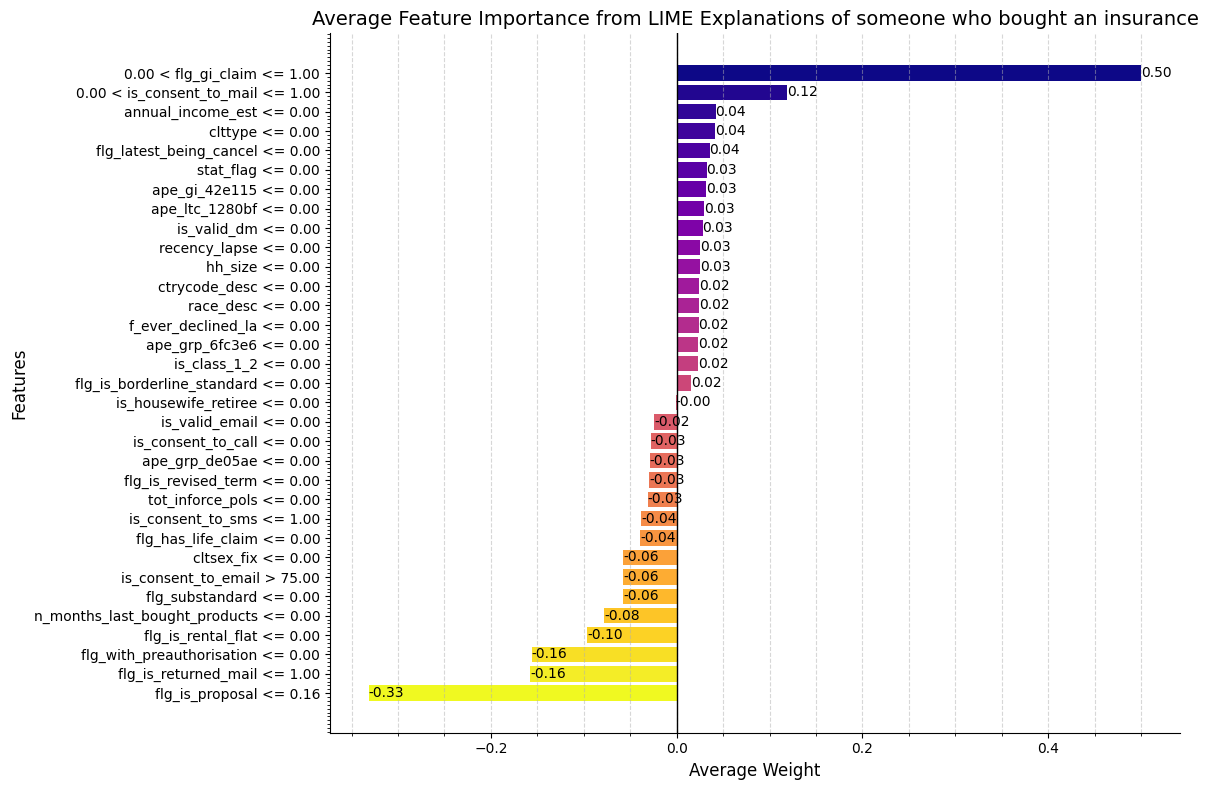

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Initialize dictionaries for sum and count of coefficients for each feature
coefficients_sum = defaultdict(float)
coefficients_count = defaultdict(int)

# Aggregate data
for explanation in test_explanations:
    for feature, coefficient in explanation:
        coefficients_sum[feature] += coefficient
        coefficients_count[feature] += 1

# Calculate average coefficient for each feature
coefficients_avg = {feature: coefficients_sum[feature] / coefficients_count[feature] for feature in coefficients_sum}

# Sort features by their average importance
sorted_features = sorted(coefficients_avg.items(), key=lambda x: x[1], reverse=True)

# Split features and their average importance for plotting
features, avg_importances = zip(*sorted_features)

# Create a bar plot with enhancements
plt.figure(figsize=(12, 8))
colors = plt.cm.plasma(np.linspace(0, 1, len(features)))
bars = plt.barh(features, avg_importances, color=colors)
plt.xlabel('Average Weight', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Average Feature Importance from LIME Explanations of someone who bought an insurance', fontsize=14)
plt.gca().invert_yaxis()  # Ensure the most important feature is on top

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(x=0, color='black', linewidth=1)

plt.grid(axis='x', which='both', linestyle='--', alpha=0.5)
plt.minorticks_on()

# Annotate each bar with the exact average weight
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}",
             va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.savefig("feature_importance_gotbuy.svg", format='svg', transparent=True)
plt.show()
